In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'CS231N/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/CS231N/assignments/assignment2/cs231n/datasets
/content


# Batch Normalization
Один из способов упростить обучение глубоких сетей — использовать более сложные процедуры оптимизации, такие как SGD+momentum, RMSProp или Adam. Другая стратегия — изменить архитектуру сети, чтобы упростить ее обучение.

Одной из идей в этом направлении является пакетная нормализация, предложенная [1] в 2015 году.


Идея относительно проста. Методы машинного обучения, как правило, работают лучше, когда их входные данные состоят из некоррелированных признаков с нулевым средним значением и единичной дисперсией. При обучении нейронной сети мы можем предварительно обработать данные, прежде чем передавать их в сеть, чтобы явно декоррелировать ее функции; это гарантирует, что первый уровень сети увидит данные, которые следуют хорошему распределению. Однако, даже если мы предварительно обработаем входные данные, активации на более глубоких уровнях сети, вероятно, больше не будут декоррелированы и больше не будут иметь нулевое среднее значение или единичную дисперсию, поскольку они выводятся из более ранних слоев сети. Хуже того, в процессе обучения распределение признаков на каждом уровне сети будет меняться по мере обновления весов каждого слоя.

Авторы [1] предполагают, что смещение распределения признаков внутри глубоких нейронных сетей может затруднить обучение глубоких сетей. Чтобы преодолеть эту проблему, [1] предлагает вставлять в сеть слои пакетной нормализации. Во время обучения уровень пакетной нормализации использует мини-пакет данных для оценки среднего значения и стандартного отклонения каждого признака. Эти оценочные средние значения и стандартные отклонения затем используются для центрирования и нормализации признаков мини-пакета. Скользящее среднее этих средних и стандартных отклонений сохраняется во время обучения, а во время тестирования эти скользящие средние значения используются для центрирования и нормализации признаков.


Возможно, что эта стратегия нормализации может снизить репрезентативную мощность сети, поскольку иногда для определенных слоев может быть оптимальным иметь признаки, которые не имеют нулевое среднее или единичную дисперсию. С этой целью уровень пакетной нормализации включает обучаемые параметры сдвига и масштабирования для каждого измерения признаков.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [ ]:
# As usual, a bit of setup
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.
	There will be an option for Colab users and another for Jupyter (local) users.


In [ ]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Batch normalization: forward
В файле `cs231n/layers.py` реализуйте прямой проход batch нормализации в функции `batchnorm_forward`. Как только вы это сделаете, запустите следующее, чтобы проверить свою реализацию.

Ссылка на статью, указанную выше в [1], может быть полезной!

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))
# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
# Now means should be close to beta and stds close to gamma
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means:  [5.99520433e-17 6.93889390e-17 8.32667268e-19]
  stds:   [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means:  [11. 12. 13.]
  stds:   [0.99999999 1.99999999 2.99999999]



In [ ]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:   [1.01531428 1.01238373 0.97819988]



## Batch normalization: backward
Теперь реализуйте обратный проход для пакетной нормализации в функции `batchnorm_backward`.

Чтобы получить обратный проход, вы должны написать граф вычислений для пакетной нормализации и обратного распространения через каждый из промежуточных узлов. Некоторые промежуточные узлы могут иметь несколько исходящих ветвей; обязательно суммируйте градиенты по этим ветвям в обратном проходе.

После того, как вы закончите, запустите следующее, чтобы численно проверить ваш обратный проход.

In [ ]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.6674604875341426e-09
dgamma error:  7.417225040694815e-13
dbeta error:  2.379446949959628e-12


## Batch normalization: alternative backward

НИЖЕ ГРАФ ВЫЧИСЛИТЕЛЬНЫЙ не верно нарисован: должно идти ещё 1 ребро из X в Y (в числителе операция: x - mx)

На уроке мы говорили о двух разных реализациях сигмовидного обратного прохода. Одна из стратегий состоит в том, чтобы написать граф вычислений, состоящий из простых операций и обратного распространения по всем промежуточным значениям. Другая стратегия заключается в выводе производных на бумаге. Например, вы можете вывести очень простую формулу для обратного прохода сигмовидной функции, упростив градиенты на бумаге.

Удивительно, но оказывается, что вы можете сделать аналогичное упрощение и для обратного прохода пакетной нормализации!

В прямом проходе, учитывая набор входных данных
 $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 



мы сначала вычисляем среднее значение $\mu$ и дисперсию $v$. Рассчитав $\mu$ и $v$, мы можем вычислить стандартное отклонение $\sigma$ и нормализованные данные $Y$. Уравнения и графическая иллюстрация ниже описывают вычисление ($y_i$ — i-й элемент вектора $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

<img src="https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/a2/batchnorm_graph.png">

Суть нашей проблемы во время обратного распространения состоит в том, чтобы вычислить $\frac{\partial L}{\partial X}$, учитывая полученный восходящий градиент, $\frac{\partial L}{\partial Y}.$ Для этого , напомним, что цепное правило в исчислении дает нам $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$ .

Неизвестная/тяжелая часть — это $\frac{\partial Y}{\partial X}$. Мы можем найти это, сначала шаг за шагом вычислив наши локальные градиенты в $\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$, $\frac {\partial \sigma}{\partial v}$, $\frac{\partial Y}{\partial \sigma}$ и $\frac{\partial Y}{\partial \mu}$, а затем используйте цепное правило для составления этих градиентов (которые появляются в виде векторов!) надлежащим образом для вычисления $\frac{\partial Y}{\partial X}$.

Если сложно напрямую рассуждать о градиентах над $X$ и $Y$, которые требуют умножения матриц, попробуйте сначала рассуждать о градиентах с точки зрения отдельных элементов $x_i$ и $y_i$: в этом случае вам нужно будет прийти с выводами для $\frac{\partial L}{\partial x_i}$, полагаясь на цепное правило, чтобы сначала вычислить промежуточные $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ затем соберите эти части для вычисления $\frac{\partial y_i}{\partial x_i}$.

Вы должны убедиться, что все промежуточные производные градиента максимально упрощены для простоты реализации.

После этого реализуйте упрощенный обратный проход пакетной нормализации в функции `batchnorm_backward_alt` и сравните две реализации, выполнив следующее. Ваши две реализации должны вычислить почти идентичные результаты, но альтернативная реализация должна быть немного быстрее.

In [ ]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  1.8705827066838603e-12
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.14x


## Fully Connected Nets with Batch Normalization
Теперь, когда у вас есть работающая реализация пакетной нормализации, вернитесь к своей сети `FullConnectedNet` в файле `cs231n/classifiers/fc_net.py`. Измените свою реализацию, чтобы добавить пакетную нормализацию.

Конкретно, когда в конструкторе для флага нормализации установлено значение `"batchnorm"`, вы должны вставить слой нормализации батча перед каждой нелинейностью ReLU. Выходы последнего слоя сети не должны быть нормализованы. Когда вы закончите, запустите следующее, чтобы проверить градиент вашей реализации.

СОВЕТ: Возможно, вам будет полезно определить дополнительный вспомогательный слой, аналогичный тем, что находятся в файле `cs231n/layer_utils.py`. Если вы решите это сделать, сделайте это в файле `cs231n/classifiers/fc_net.py`.

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 3.11e-06
W3 relative error: 4.05e-10
b1 relative error: 1.78e-07
b2 relative error: 2.66e-07
b3 relative error: 1.01e-10
beta1 relative error: 7.33e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 6.96e-09
gamma2 relative error: 2.41e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.29e-06
W3 relative error: 2.79e-08
b1 relative error: 4.44e-08
b2 relative error: 7.77e-07
b3 relative error: 2.10e-10
beta1 relative error: 6.65e-09
beta2 relative error: 3.39e-09
gamma1 relative error: 6.27e-09
gamma2 relative error: 5.28e-09


# Batchnorm for deep networks
Запустите следующее, чтобы обучить шестислойную сеть на подмножестве из 1000 обучающих примеров как с пакетной нормализацией, так и без нее.

In [ ]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.107000; val_acc: 0.115000
(Epoch 1 / 10) train acc: 0.314000; val_acc: 0.266000
(Iteration 21 / 200) loss: 2.039344
(Epoch 2 / 10) train acc: 0.395000; val_acc: 0.279000
(Iteration 41 / 200) loss: 2.047471
(Epoch 3 / 10) train acc: 0.485000; val_acc: 0.315000
(Iteration 61 / 200) loss: 1.739554
(Epoch 4 / 10) train acc: 0.523000; val_acc: 0.318000
(Iteration 81 / 200) loss: 1.246973
(Epoch 5 / 10) train acc: 0.590000; val_acc: 0.339000
(Iteration 101 / 200) loss: 1.358532
(Epoch 6 / 10) train acc: 0.641000; val_acc: 0.322000
(Iteration 121 / 200) loss: 0.974635
(Epoch 7 / 10) train acc: 0.657000; val_acc: 0.328000
(Iteration 141 / 200) loss: 1.202126
(Epoch 8 / 10) train acc: 0.675000; val_acc: 0.299000
(Iteration 161 / 200) loss: 0.792631
(Epoch 9 / 10) train acc: 0.773000; val_acc: 0.334000
(Iteration 181 / 200) loss: 0.790706
(Epoch 10 / 10) train acc: 0.750000; val_acc: 0.308000

Solver without b

Запустите следующее, чтобы визуализировать результаты двух сетей, обученных выше. Вы должны обнаружить, что использование пакетной нормализации помогает сети сходиться намного быстрее.

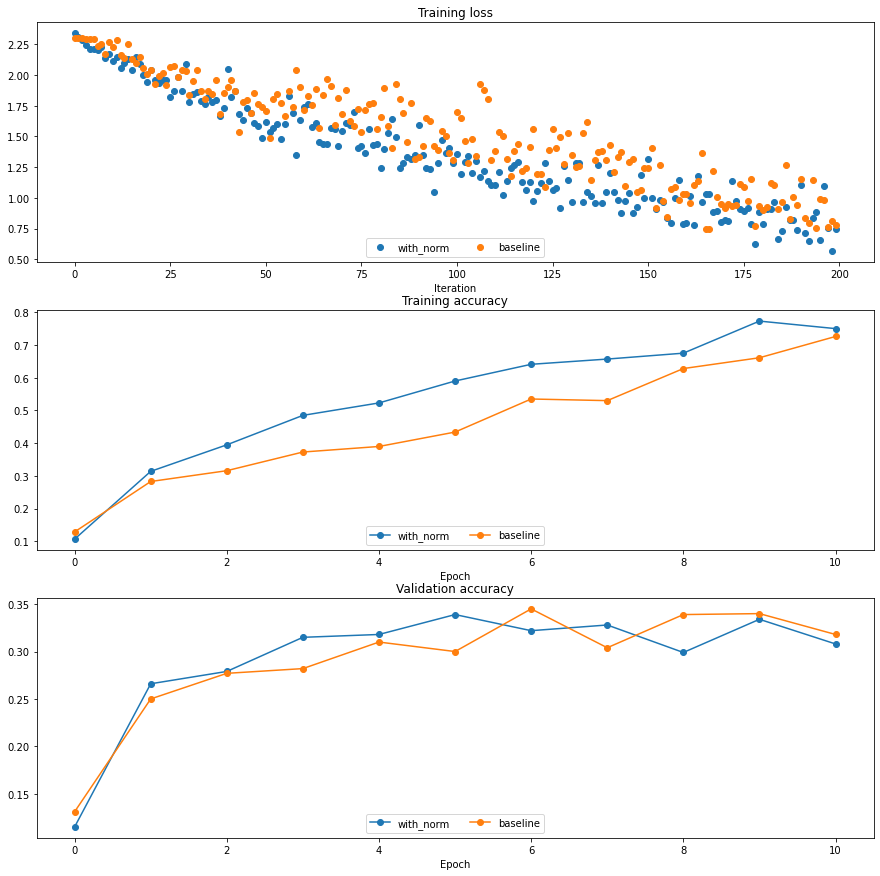

In [ ]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization and initialization
Теперь мы проведем небольшой эксперимент, чтобы изучить взаимодействие батч нормализации и инициализации веса.


Первая ячейка будет обучать 8-слойные сети как с батч нормализацией, так и без нее, используя разные масштабы (с.к.о) для инициализации весов. Вторая ячейка  будет отображать точность на  обучающей выборке, точность на валидационной выборке и training loss в зависимости от масштаба инициализации веса.

In [ ]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

    bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers_ws[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    solver.train()
    solvers_ws[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


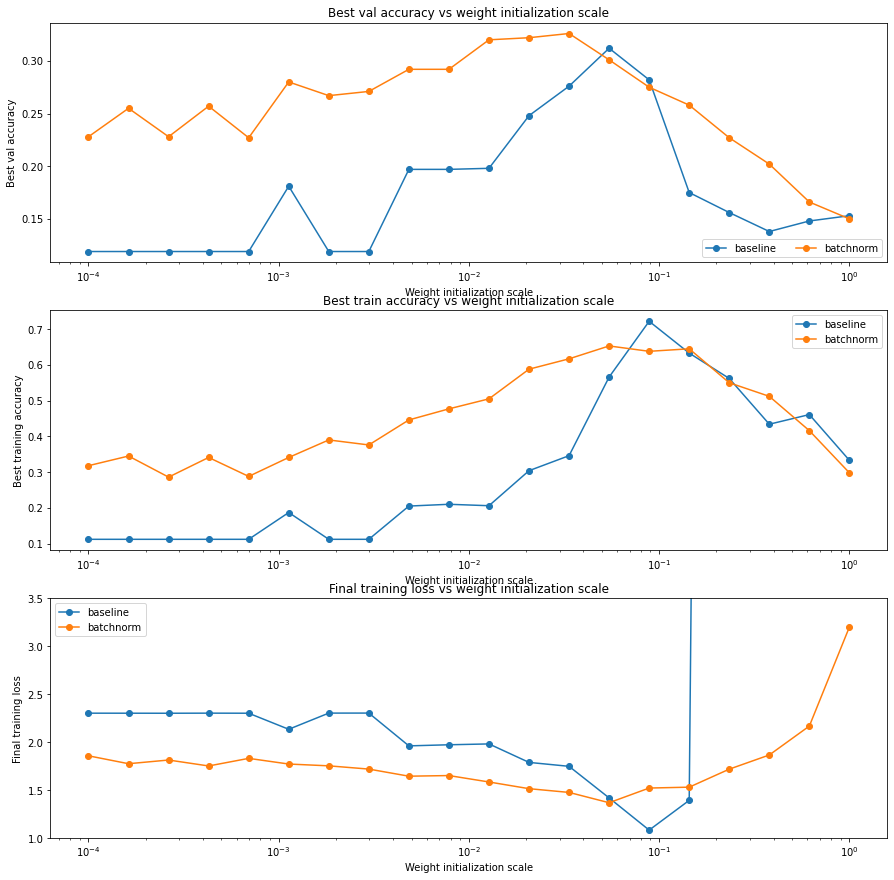

In [ ]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers_ws[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))
  
  best_val_accs.append(max(solvers_ws[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
Опишите результаты этого эксперимента. Как масштаб инициализации весов по-разному влияет на модели с/без пакетной нормализацией и почему?

## Answer:
Были обучены сети с 7ю скрытыми слоями. Размер батча 50, кол-во эпох обучения 10, тренировочная выборка 1000, валидационная 1000. Алгоритм обновления весов модели Adam. Всего было обучено 20 сетей без батч нормализации и 20 сетей с батч нормализацией. Каждая из 20 пар сетей имела разные коэффциенты масштабирования (с.к.о) начальной инициализации весов (всего 20 шт). Начальная скорость обучения одинакова для всех моделей: 10^(-3). Коэффициент штрафа L2 регуляризации = 0.

Сети с использованием батч нормализации почти всегда имели бОльшие значения train acc., bestval acc., и меньшие значения train loss чем сети без нормализации с таким же масштабом инициализации весов. Так как сети без батч нормализации либо не обучались (затухающие градиенты) из-за слишком маленького масштаба инициализации, либо "взрывались" и не сходились (черезмерно большие градиенты) в следствие большого масштаба инициализации весов. Как видно из 3-его графика со средними значениями training loss (среднее из 100 последних итераций) для сети без нормализации. Где при коэффициенте масштабирования весов больше чем 1*10^(-1) значение средней ошибки "взрывается" и достигает больших значений, что говорит от том что масштаб весов повлиял на градиенты проходящие через слои и они оказались слишком большие. Кроме того, вероятно, что небольшие изменения весов в начальных слоях сети приведут к большим изменениям в распределении входов в последующие слои сети.

При значениях масштаба весов меньше 10^(-2) ошибка сети без нормализации даже после 20 эпох обучения близка к 2.3, что для сети с классификатором softmax (cross entropy loss) для 10 классов соответсвует значению ошибки не обученной, случайно инициализированной сети. Это говорит о том, что градиенты были очень маленькими и соответственно обновление весов тоже слишком маленькое, в итоге сеть не обучалась. А сеть с батч нормализацией при тех же масштабах инициализации весов имееют ошибку значительно меньше 2.3 что свидетельствует об обучении.

Однако сеть без батч нормализации при инициализации весов с коэффициентом масштабирования близким к 1e-1 показала большую bestval acc и train acc, а также меньшую train loss чем аналогичная сеть с батч нормализацией. При этом лучший показатель best val принадлежит сети с батч нормализацией. Это связано с тем что батч нормализация действует еще и как стохатсический регуляризатор за счет внесения шума в слоях нормализации, так как оценки числовых характеристик распределений (мат. ожид, дисперсия) признаков вычисляются по батчу в котором присутствуют случайно выбранные экземпляры данных.

Batch normalization обладает следующими полезными свойствами:
- уменьшает чувствительность сети к начальной инициализации весов;
- использование нормализации перед функцией активации позволяет использовать значительно большие скорости обучения не опасаясь затухания градиентов при насыщении функций активации (например sigmoid);
- предотвращает "взрыв" модели в случае когда небольшие изменения в весах модели сильно влияют на распределения выходов на последующих слоях; 
- уменьшает внутренний ковариантный сдвиг (`internal covariate shift` из статьи S.Ioffe, C.Szegedy), тем самым сеть обучается быстрее и стабильнее;
- гиперповерхность функции ошибки становится более "гладкой", менее "зашумленной";
- при использовании батчей не очень большого размера (SGD) имеет место быть элемент случайности в вычислении оценок численных характеристик распределений признаков случайно выбранных из набора данных в батч. Это оказывает влияние как стохастических регуляризатор уменьшая переобучение и улучшая обобщение модели;
- масштаб весов не влияет на градиент проходящий через этот слой (градиент входов);
- стабилизируется праметр роста градиента весов (см. статью).

# Batch normalization and batch size
Теперь мы проведем небольшой эксперимент, чтобы изучить взаимодействие батч нормализации и размера батча.

Первая ячейка будет обучать 6-слойные сети как с батч нормализацией, так и без нее, используя разные размеры пакетов. Второй слой будет отображать точность данных для обучения и точность на валидационном наборе с течением времени.

In [ ]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    # Try training a very deep net with batchnorm
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


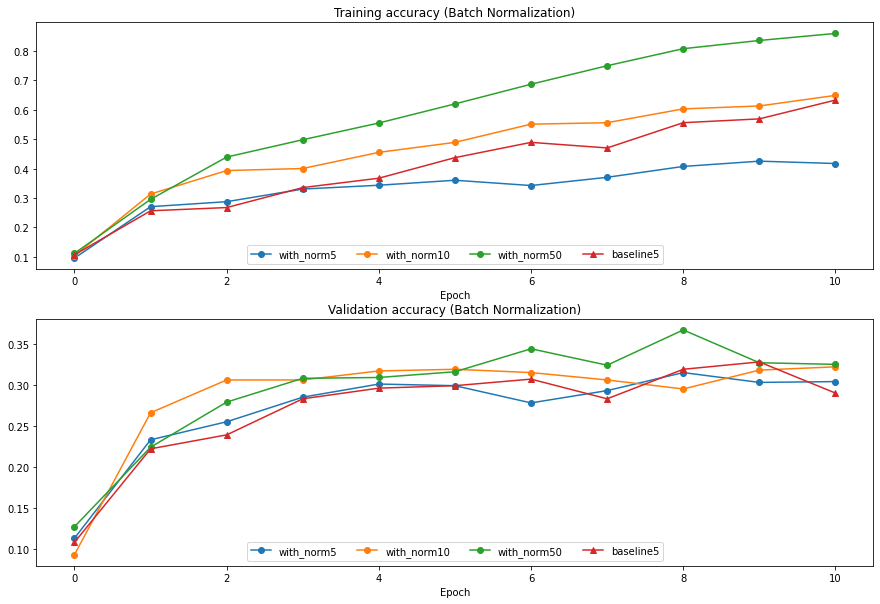

In [ ]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 2:
Опишите результаты этого эксперимента. Что это говорит взаимосвязи батч нормализации и размера батча? Почему наблюдается эта зависимость?

## Answer:
Были обучены 4 полносвязные сети с 5ю скрытыми слоями. 3 сети из них с слоями батч нормализаци. Размеры батчей при обучении: 5, 10, 50. Сеть без слоев нормализации обучалась по батчам размером 5. Сети обучались на тренировочном наборе из 1000 и оценивались на наборе из 1000 экземпляров. Количество эпох обучения 10. Алгоритм обновления весов Adam.

Из результата эксперимента видо, что чем больше размер батча, тем быстрее и стабильнее сеть обучается. Но при размере батча = 5 сеть с нормализацией показала результат на обучающей выборке хуже, чем сеть без нормализации. Это связано с тем, что нормировка результатов линейных преобразований происходит на малом количестве экземпляров входных данных вследствие чего оценки численных характеристик распределений (мат. ожид, дисперсия) сильно зашумлены (добавляют шум к полезному сигналу так что "перебивают" его) и в зависимости от батча к батчу могут сильно меняться. И проблема внутреннего ковариантного сдвига остается. К тому же обучаемые веса слоя нормализации: параметры масштаба и сдвига (gamma, beta) подвержены большому шуму. Так как при расчете градиентов используются статистические оценки распределений: мат. ожид, дисперсии. И соответственно после очередной итерации обновления весов и параметров gamma, beta на вход следующего слоя подаются результаты линейных преобразований искаженные шумом самих весов нейронов, так еще и вносят шум параметры gamma, beta. Это оказывает на обучение сети бОльшее негативное влияние, чем обучение сети без батч нормализации с тем же размером батча.

Чем больше размер батча, тем менее менее выражен внутренний ковариантный сдвиг и менее зашумлены обновления параметов gamma и beta.

Если взять очень большие размеры батчей (например 500) и оставить таким же кол-во эпох = 10, то скорость обучения сети упадет. Это связано с тем что кол-во итераций для обновления параметров весов = 1000/500 * 10 = 20 - мало. А для батча размера 5 имеем 1000/5 * 10 = 2000 итераций. Тогда следует увеличить кол-во эпох или скорость обучения. Замечено что при больших размерах пакетов, например 500 и кол-ве эпох = 50 обобщающая способность сети хуже (vall acc меньше при том, что train acc почти достигает 1) чем у сетей с меньшим размером батча. Это связано с тем что эффект стохастической регуляризации уменьшается, так как при увеличении размера батча уменьшается шум в оценках численных характеристик распределений признаков.



# Layer Normalization
Пакетная нормализация доказала свою эффективность в упрощении обучения сетей, но зависимость от размера пакета делает ее менее полезной в сложных сетях, которые имеют ограничение на размер входного пакета из-за аппаратных ограничений.

Для решения этой проблемы было предложено несколько альтернатив пакетной нормализации; одним из таких методов является нормализация слоя [2]. Вместо нормализации пакета мы нормализуем признаки. Другими словами, при использовании нормализации слоя каждый вектор признаков, соответствующий одной точке данных, нормализуется на основе суммы всех членов в этом векторе признаков.

[2] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)

## Inline Question 3:

Какой из этих шагов предварительной обработки данных аналогичен пакетной нормализации, а какой аналогичен нормализации слоев?

1. Масштабирование каждого изображения в наборе данных, чтобы сумма каналов RGB для каждой строки пикселей в изображении равнялась 1.

2. Масштабирование каждого изображения в наборе данных, чтобы сумма каналов RGB для всех пикселей изображения равнялась 1.

3. Вычитание среднего изображения набора данных из каждого изображения в наборе данных.

4. Установка всех значений RGB на 0 или 1 в зависимости от заданного порога.

## Answer:
Так как каждый пиксель это признак, тогда для RGB изображения на каждый пиксель приходится по 3 признака.

1 - Не подходит ни к одному варианту, так как признаки каждого изображения (значения rgb пикселей) не нормализуются с учетом значений пикселей других изображений или с учетом значений всех пикселей этого же изображения.

2 - Нормализация по слоям, так как для каждого изображения нормализуются его признаки с учетом всех признаков (пикселей) этого же изображения.

3 - Нормализация по пакету: центрирование значений пикселов (gamma = (Dx)^(1/2), beta = 0).

4 - Ни то и ни другое. Так как в результате такой предобработки получаются распределения признаков которые отличаются различными мат. ожиданиями и соответственно дисперсиями. То есть нормализации как таковой нет. 

# Layer Normalization: Implementation

Теперь вы реализуете нормализацию слоя. Этот шаг должен быть относительно простым, так как концептуально его реализация почти идентична пакетной нормализации. Однако одно существенное отличие заключается в том, что при нормализации слоев мы не отслеживаем скользящие моменты, а этап тестирования идентичен этапу обучения, где среднее значение и дисперсия рассчитываются непосредственно для каждой точки данных.

Вот что вам нужно сделать:

* В `cs231n/layers.py` реализуйте прямой проход для нормализации слоя в функции `layernorm_forward`.

Запустите ячейку ниже, чтобы проверить свои результаты. 
* В `cs231n/layers.py` реализуйте обратный проход для нормализации слоя в функции `layernorm_backward`.

Запустите вторую ячейку ниже, чтобы проверить свои результаты. 
* Измените `cs231n/classifiers/fc_net.py`, чтобы добавить нормализацию слоя в `FullyConnectedNet`. Когда в конструкторе для флага `normalization` установлено значение `«layernorm»`, вы должны вставить слой нормализации слоя перед каждой нелинейностью ReLU.

Запустите третью ячейку ниже, чтобы запустить эксперимент с размером партии при нормализации слоя.

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after layer normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 =4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before layer normalization:')
print_mean_std(a,axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)
# Means should be close to zero and stds close to one
print('After layer normalization (gamma=1, beta=0)')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

gamma = np.asarray([3.0,3.0,3.0])
beta = np.asarray([5.0,5.0,5.0])
# Now means should be close to beta and stds close to gamma
print('After layer normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

Before layer normalization:
  means:  [-59.06673243 -47.60782686 -43.31137368 -26.40991744]
  stds:   [10.07429373 28.39478981 35.28360729  4.01831507]

After layer normalization (gamma=1, beta=0)
  means:  [ 4.81096644e-16 -7.40148683e-17  2.22044605e-16 -5.92118946e-16]
  stds:   [0.99999995 0.99999999 1.         0.99999969]

After layer normalization (gamma= [3. 3. 3.] , beta= [5. 5. 5.] )
  means:  [5. 5. 5. 5.]
  stds:   [2.99999985 2.99999998 2.99999999 2.99999907]



In [ ]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

#You should expect to see relative errors between 1e-12 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.107279036881856e-09
dgamma error:  4.519489546032799e-12
dbeta error:  2.5842537629899423e-12


# Layer Normalization and batch size

Теперь мы запустим предыдущий эксперимент с размером партии с нормализацией слоя вместо нормализации партии. По сравнению с предыдущим экспериментом вы должны увидеть заметно меньшее влияние размера партии на историю обучения!

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


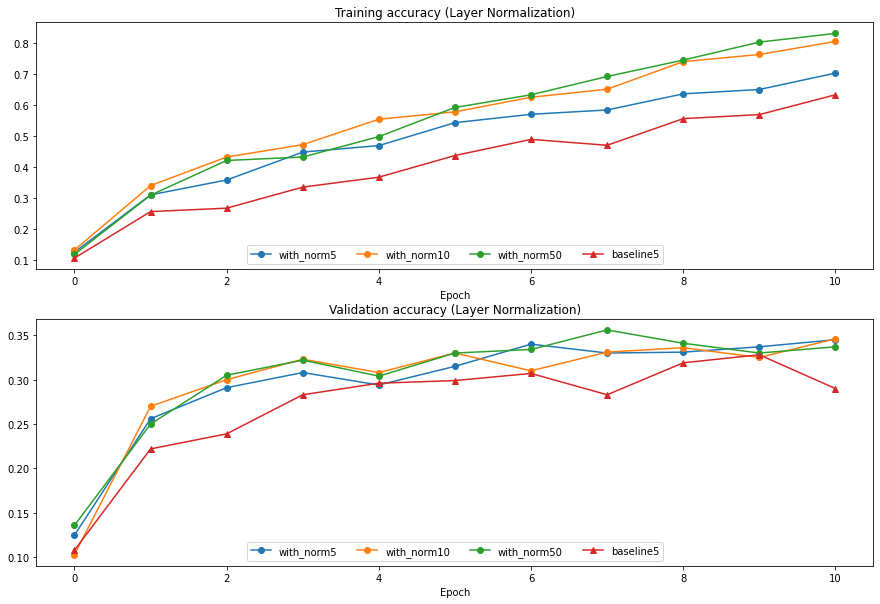

In [ ]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('layernorm')

plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 4:
Когда нормализация слоя может не сработать и почему?

1. Использование его в очень глубокой сети
2. Имея очень маленькую размерность признаков
3. Имея высокое значение регуляризации

## Answer:

1. Не верно. Принципиально нормализация при наличии большкого количества скрытых слоев не отличается от не глубокой сети, например с 5-ю скрытми слоями расмотренной выше.

2. Верно, может не сработать аналогично случаю с размером батча при батч нормализации. Так, имея маленькую размерность скрытых слоев, мы получим что некоторые результаты линейных преобразований будут нормализованы с сильно разными статистическими оценками (мат. ожид., дисперсия) даже если они одного и того же класса. А значит при обучении веса и параметры gamma, beta  будут подвержены большому шуму (при расчете градиентов используются статистические оценки распределений: мат. ожид, дисперсия). Чем меньше размерность признаков тем больше шума при обучении может быть. Но и следует упомянуть тот факт, что чем меньше признаков в скрытых слоях тем меньше репрезентативная сила сети.

3. Верно. Имея большое значения параметра регуляризации, мы получим большие градиенты весов. А значит градиент от регуляризации будет предобладать над градиентами от data loss при обновлении весов модели. В результате чего может получится так, что обновленные веса модели сильно повлияют на распределение признаков перед функцией активации. По сути изменив область определения функции активации и соотвественно распределение выходов слоя, что и представляет собой внутренний ковариантный сдвиг.

- проверка использования нормализация слоя в:
1. очень глубокой сети
2. имея очень маленькую размерность признаков
3. имея высокое значение регуляризации

In [ ]:
from numpy.random.mtrand import noncentral_chisquare
def run_layernorm_experiments(normalization_mode, test_parameter, batch_size = 50, hidden_layers_sizes = 5*[100], reg_strength = 0 ):
    np.random.seed(231)
    # Try training a very deep net with layer normalization
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs= 20
    weight_scale = 2e-2
    lr = 10**(-3.5)
    solver_bsize = batch_size

    test_param_name = list(test_parameter.keys())[0]
    param_values = test_parameter[test_param_name]

    print('No normalization: {0} = {1}'.format(test_param_name,param_values[0])) # первый параметр идет дефолтный
    model = None
    if test_param_name == "network_depth":
      model = FullyConnectedNet(param_values[0]*[100], weight_scale=weight_scale, normalization=None, reg = reg_strength)
      n_epochs = 40
          
    if test_param_name == "hidden_dims":
      model = FullyConnectedNet(param_values[0], weight_scale=weight_scale, normalization=None, reg = reg_strength)

    if test_param_name == "reg_strength":
      model = FullyConnectedNet(hidden_layers_sizes, weight_scale=weight_scale, normalization=None, reg = param_values[0])

    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    test_param_solvers = []
    for i in range(len(param_values)):
        param_value=param_values[i]
        print('Normalization: {0} = {1}'.format(test_param_name,param_value))
        test_param_model = None
        if test_param_name == "network_depth":
          test_param_model = FullyConnectedNet(param_value*[100], weight_scale=weight_scale, normalization=normalization_mode, reg = reg_strength)
          
        if test_param_name == "hidden_dims":
          test_param_model = FullyConnectedNet(param_value, weight_scale=weight_scale, normalization=normalization_mode, reg = reg_strength)

        if test_param_name == "reg_strength":
          test_param_model = FullyConnectedNet(hidden_layers_sizes, weight_scale=weight_scale, normalization=normalization_mode, reg = param_value)

        
        test_param_solver = Solver(test_param_model, small_data,
                        num_epochs=n_epochs, batch_size=solver_bsize,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        test_param_solver.train()
        test_param_solvers.append(test_param_solver)
        
    return test_param_solvers, solver

In [ ]:
def plot_training_history2(title, label, baseline, test_param_solvers, plot_fn, param_label, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    test_param_plots = [plot_fn(solver) for solver in test_param_solvers]
    bl_plot = plot_fn(baseline)
    num_test_param_plot = len(test_param_plots)
    for i in range(num_test_param_plot):
        label=param_label +"_"
        if labels is not None:
            label += str(labels[i])
        plt.plot(test_param_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_test_param_plot+1) 


No normalization: hidden_dims = [10, 10, 10, 10, 10]
Normalization: hidden_dims = [10, 10, 10, 10, 10]
Normalization: hidden_dims = [25, 25, 25, 25, 25]
Normalization: hidden_dims = [50, 50, 50, 50, 50]
Normalization: hidden_dims = [100, 100, 100, 100, 100]


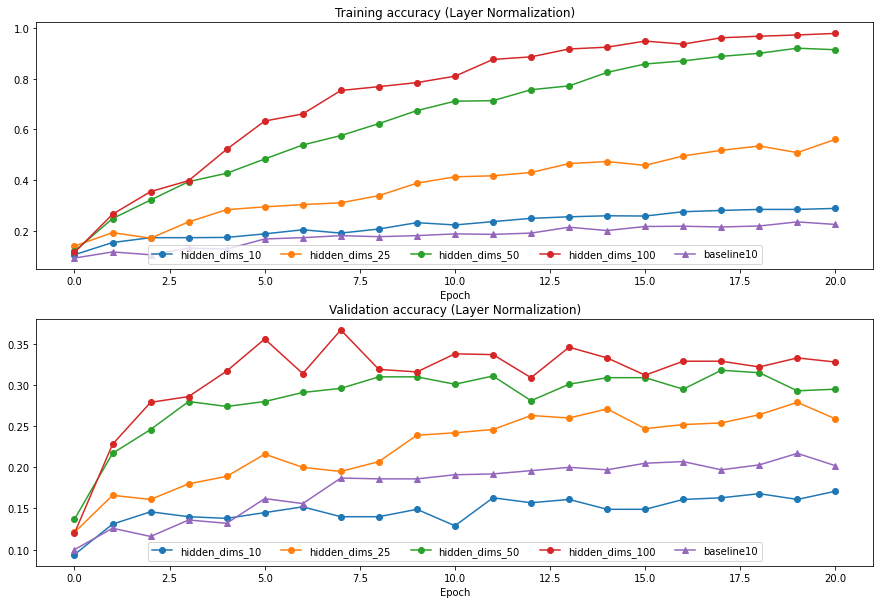

In [ ]:
layer_norm_solvers, default_solver = run_layernorm_experiments('layernorm', test_parameter = {"hidden_dims": [5*[10],5*[25],5*[50],5*[100]]})

plt.subplot(2, 1, 1)
plot_training_history2('Training accuracy (Layer Normalization)','Epoch', default_solver, layer_norm_solvers, \
                      lambda x: x.train_acc_history, param_label = "hidden_dims", bl_marker='-^', bn_marker='-o', labels=[10, 25, 50, 100])
plt.subplot(2, 1, 2)
plot_training_history2('Validation accuracy (Layer Normalization)','Epoch', default_solver, layer_norm_solvers, \
                      lambda x: x.val_acc_history, param_label = "hidden_dims", bl_marker='-^', bn_marker='-o', labels=[10, 25, 50, 100])

plt.gcf().set_size_inches(15, 10)
plt.show()

No normalization: reg_strength = 0
Normalization: reg_strength = 0
Normalization: reg_strength = 0.001
Normalization: reg_strength = 0.01
Normalization: reg_strength = 0.1
Normalization: reg_strength = 1
Normalization: reg_strength = 5
Normalization: reg_strength = 10


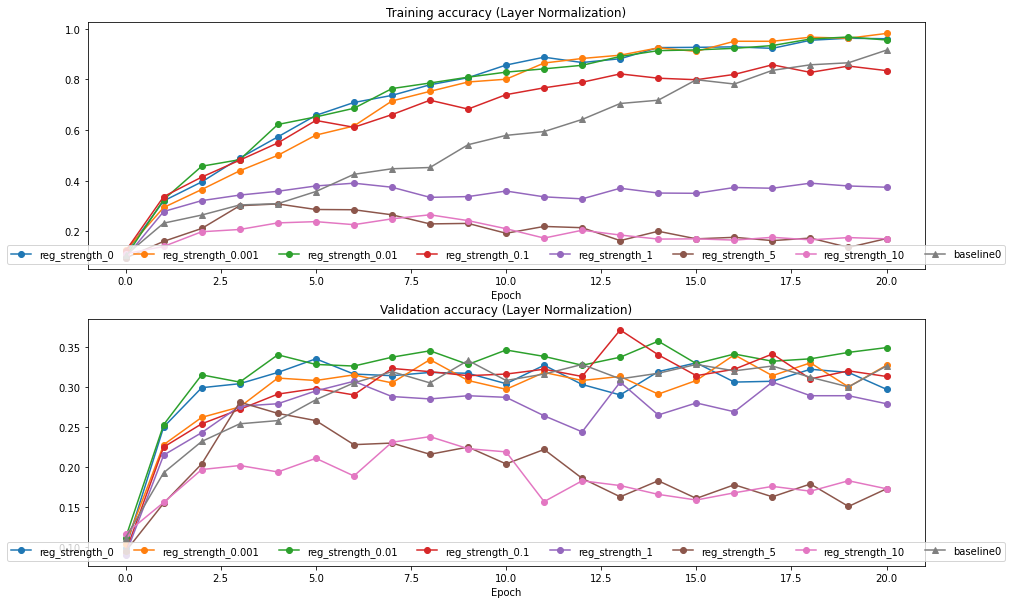

In [ ]:
layer_norm_solvers, default_solver = run_layernorm_experiments('layernorm', test_parameter = {"reg_strength": [0,1e-3,1e-2,1e-1,1,5,10]})

plt.subplot(2, 1, 1)
plot_training_history2('Training accuracy (Layer Normalization)','Epoch', default_solver, layer_norm_solvers, \
                      lambda x: x.train_acc_history, param_label = "reg_strength", bl_marker='-^', bn_marker='-o', labels=[0,1e-3,1e-2,1e-1,1,5,10])
plt.subplot(2, 1, 2)
plot_training_history2('Validation accuracy (Layer Normalization)','Epoch', default_solver, layer_norm_solvers, \
                      lambda x: x.val_acc_history, param_label = "reg_strength", bl_marker='-^', bn_marker='-o', labels=[0,1e-3,1e-2,1e-1,1,5,10])

plt.gcf().set_size_inches(15, 10)
plt.show()